In [0]:
#Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
%matplotlib inline

## Functions for optmization:

In [0]:
class TestFunctions():
  def rosenbrock(self,x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


  def sphere(self,x):
    """The Sphere function"""
    return sum(i*i for i in x)


  def rastrigin(self,x):
    """The Rastrigin function"""
    return 10 * len(x) + sum(i * i - 10 * np.cos(2 * np.pi * i) for i in x)


  def himmelblau(self,x):
    """The Himmelblau function"""
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2


  def ackley(self,x):
    """The Ackley function"""
    dim = len(x)
    sum1 = 0
    sum2 = 0
    for i in range(dim):
        sum1 += x[i]**2
        sum2 += np.cos(2*np.pi*x[i])

    return -20*np.exp(-0.2*np.sqrt(sum1/dim)) - np.exp(sum2/dim) + 20 + np.e


  def levi_13(self,x):
    """The Levy Function N. 13"""
    return np.sin(3*np.pi*x[0])**2 + (x[0] - 1)**2*(1 + np.sin(3*np.pi*x[1])**2) + (x[1] - 1)**2*(1 + np.sin(2*np.pi*x[1])**2)


  def matyas(self,x):
    """The Matyas function"""
    return (0.26 * (x[0]**2 + x[1]**2)) - (0.48 * x[0] * x[1])


  def booth(self,x):
    """The Booth function"""
    return ((x[0] + 2*x[1] - 7)**2) + ((2*x[0] + x[1] +-5)**2)
  
  def beale(self,x):
    """ The Beale function """
    return (1.5-x[0]+(x[0]*x[1]))**2 + (2.25-x[0]*x[0]*x[1]**2)**2 + (2.625-x[0]+x[0]*x[1]**3)**2

## Parameters:

In [0]:
n = 30                # Particles
m = 3000              # Iterations
n_dimensions = 2      # Number of dimensions
min_ = -50.           # Search space size
max_ = min_ * -1      # Seach space size  
L = abs(max_-min_)    # Maximum radius of the search space

initial_inertia = 0.4 # Inertial weight
final_inertia = 0.7   # Inertial weight
c1 = 1.5              # Cognitive coefficient
c2 = 1.5              # Social coefficient
c_max= 3              # Max consecutive evaluations before finish optmizing

d_low = 1e-6          # Lower threshold for diversity control
d_high = 0.25         # Upper threshold for diversity control

f_name = 'levi_13'    # Select your optmization

## Auxiliary Funcitons:

In [0]:
def calculate_diversity_and_dir(swarm,dir_):
  """  Calculates the diversity factor, 
       which may be -1 (repulsion phase) or 1 (attraction phase)
  """
  mean = np.mean(swarm, axis=0)
  summ = 0
  for k in range(n):
    summ += np.sqrt( np.sum( swarm[k] - mean ) **2 )
  diversity = 1./(n*L) * summ
  
  if diversity < d_low:
    dir_ = -1
  elif diversity > d_high:
    dir_ = 1
  
  return diversity, dir_

In [0]:
# TODO: refetorar com map()
#Entender melhor como funcionam as derivadas parciais
def calculate_partial_derivative(objective_function, particle, i):
  h = 1e-5
  x = particle
  xi = x[i]
  
  x[i] = xi + h
  func_plus_h = objective_function(x)

  x[i] = xi - h
  func_minus_h = objective_function(x)

  return (func_plus_h - func_minus_h) / (2*h)


In [0]:
# Calculates the gradient:
def calculate_gradient(objective_function, particle):
    gradient = [calculate_partial_derivative(objective_function, particle, i) for i in range(n_dimensions)]
    return np.array(gradient)

In [0]:
def plot_swarm(swarm):
  '''
    Plot swarm movimentation through the search space
  '''
  x = [position[0] for position in swarm]
  y = [position[1] for position in swarm]
  plt.scatter(x, y)

## ***SAPSO***

In [0]:
def sapso(n, m, n_dimensions, miin, maax, initial_inertia, final_inertia, c1, c2, c_max, d_low, d_high, f_name):
  #TODO: docstring later on
  '''
    The Semi Autonomus particle swarm optmizer
  '''
  fig = plt.figure(figsize=(9,9))                 # Object for ploting
  plt.title('Particles moving through search space')
  
  swarm = np.zeros((n, n_dimensions))             # Current position of all swarm's particles
 
  velocities = np.zeros((n, n_dimensions))        # Particle's velocities    
  
  v_max = abs(maax - miin)/2                      # Maximum velocities
 
  best_global_position = np.zeros((n_dimensions)) # Memory of best ever found position
 
  fitness_list = np.zeros(n)                      # A list of current fitness o evey particle. reseted every cycle

  best_global_fitness = 0.0                       # Memory of best ever found fitness
  
  I = np.zeros((n))                               # Variável para decidir qual dos componentes da equação usar (Preciso entender melhor essa parte)
    
  counter = np.zeros((n))                         # Responsible for changing the I variable state (esse contador é quem mostrará o momento de trocar para a componente social ou gradient)
   
  ep = 1e-3                                       # Variável usada na decisão de mudar o estado de I (tolerância)
    
  dir_ = 1                                        # Direction [1 (attraction) or -1 (repulsion)]
  
  diversity = 0.                                  # Diversity factor

  best_fitness_history = []                       # Best fitness history (for each iteration)

  objective_function = getattr(TestFunctions(),f_name)
  
  # For each particle:
  for k in range(n):
      #Start it at a random location:
      swarm[k] = np.array([miin + np.random.uniform()*(maax-miin) for i in range(n_dimensions)])
  
  # Initiate best global position using positions of the first swarm's particle:
  best_global_position = swarm[0]
  # Initiate best fitness:
  fitness_list = list(map(objective_function,swarm))
  #Initiate best global fitness:
  best_global_fitness = min(fitness_list)

  
  # Main loop:
  for i in range(m):
      #Visualize swarm every 100 iterations:
      if (m % 100 == 0): plot_swarm(swarm)
      #Calculate inertia as a function of remaining iterations
      inertia = (initial_inertia - (initial_inertia - final_inertia)) * (i/m); 
      
      #For each particle:
      for k in range(n):
          # Reset new_position and gradient information:
          new_position = np.zeros((n_dimensions))
          gradient = np.zeros((n_dimensions))
          
          #If particle is following gradient information,calculate it:
          if I[k] == 0:
              gradient = calculate_gradient(objective_function, swarm[k])
          
          phi_1 = np.random.uniform(size=n_dimensions)
          phi_2 = np.random.uniform(size=n_dimensions)
          velocity = (inertia*velocities[k]) + dir_ * (I[k]*c1*phi_1*(best_global_position - swarm[k]) + (I[k]-1)*c2*phi_2*gradient)

          #For each dimension:
          for j in range(n_dimensions):
              #Validate velocity:
              if velocity[j] > v_max: velocity[j] = 0
              if velocity[j] < -v_max: velocity[j] = 0
              
              new_position[j] = swarm[k][j] + velocity[j]
              # Validate position:
              if new_position[j] > maax: 
                new_position[j] = maax
                velocity[j] = 0 # check to see if this is correct

              if new_position[j] < miin:
                new_position[j] = miin
                velocity[j] = 0 # check to see if this is correct
          
          swarm[k] = new_position
          velocities[k] = velocity
          fitness = objective_function(swarm[k])
          
          # if I = 0 particle is following gradient information
          # if I = 1 particle is following global best information
          #differently from other pso version, in sapso a particle can either follow one or another direction (in addition to alway following )
          
          #Check to see if we are improving fitness through iterations:
          if I[k] == 0:
              if abs(fitness - fitness_list[k]) <= ep:
                  counter[k] += 1
                  #If SAPSO can not improve fitness in 'c_max' iterations: then 'I' is 1 (particle will go onto the best global instead of gradient information)
                  if counter[k] == c_max:
                      I[k] = 1
                      counter[k] = 0
              else:
                  counter[k] = 0
          
          else:
              if np.sqrt(np.sum((swarm[k] - best_global_position)**2)) < ep:
                  I[k] = 0
          
          fitness_list[k] = fitness
          
          #Verify if it's a new global best:
          if fitness < best_global_fitness:
              best_global_fitness = fitness
              best_global_position = new_position
      
      #Recalculate diversity
      diversity, dir_ = calculate_diversity_and_dir(swarm,dir_)
      best_fitness_history.append(best_global_fitness)
  #recreating the fig object for new and final plot:
  fig = plt.figure(figsize=(9,9))
  plt.title('Final Position of particles')
  plot_swarm(swarm)
  return best_fitness_history, best_global_position

In [62]:
'''
Test Functions that are working nicely:
1- Rastrigin
2- Ackley
3- Sphere
4- Booth
5- Levi 13

Test Functions that are not working well:
1- Rosenbrock
2- Beale

Test functions for optimization:
https://en.wikipedia.org/wiki/Test_functions_for_optimization
'''

'\nTest Functions that are working nicely:\n1- Rastrigin\n2- Ackley\n3- Sphere\n4- Booth\n5- Levi 13\n\nTest Functions that are not working well:\n1- Rosenbrock\n2- Beale\n\nTest functions for optimization:\nhttps://en.wikipedia.org/wiki/Test_functions_for_optimization\n'

In [63]:
10 % 30 == 0

False

## Usage example: 

Best fitness found was [-1.12255172e-05 -3.23346139e-05] 
 and actual global minimum is[0, 0]
difference is: [-1.12255172e-05 -3.23346139e-05]


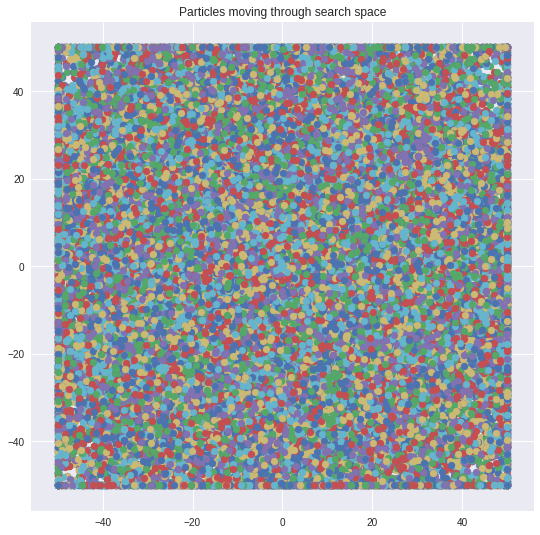

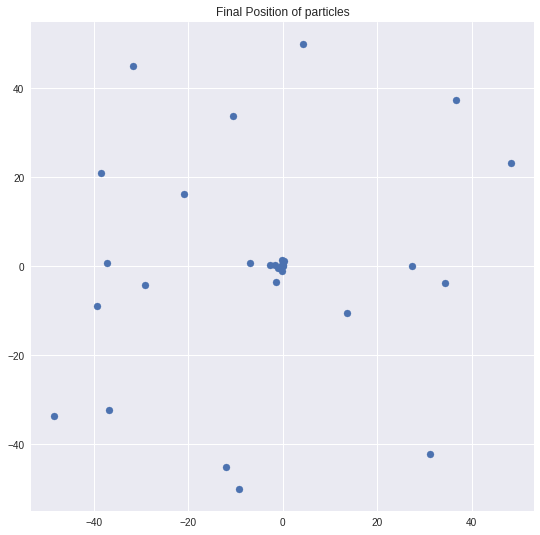

In [64]:
f_name = 'rastrigin'
best_fitness_history, best_global_position = sapso(n, m, n_dimensions, min_, max_, initial_inertia, final_inertia, c1, c2, c_max, d_low, d_high, f_name)
global_minimum = [0,0]

print('Best fitness found was {} \n and actual global minimum is{}'.format(best_global_position,global_minimum))
print('difference is: {}'.format(best_global_position-global_minimum))

Best fitness found was [ 3.06523092e-05 -2.94634282e-05] 
 and actual global minimum is[0, 0]
difference is: [ 3.06523092e-05 -2.94634282e-05]


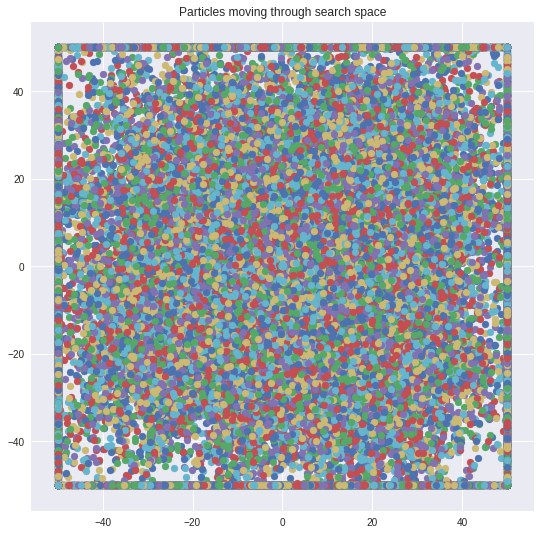

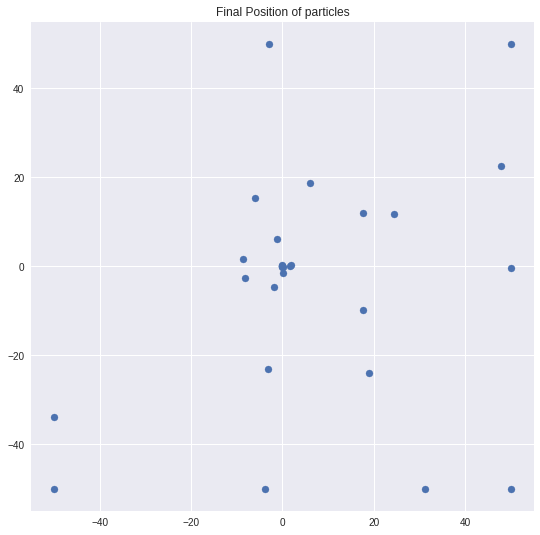

In [65]:
f_name = 'ackley'
best_fitness_history, best_global_position = sapso(n, m, n_dimensions, min_, max_, initial_inertia, final_inertia, c1, c2, c_max, d_low, d_high, f_name)
global_minimum = [0,0]

print('Best fitness found was {} \n and actual global minimum is{}'.format(best_global_position,global_minimum))
print('difference is: {}'.format(best_global_position-global_minimum))


Best fitness found was [-2.5876988e-08 -9.1131435e-08] 
 and actual global minimum is[0, 0]
difference is: [-2.5876988e-08 -9.1131435e-08]


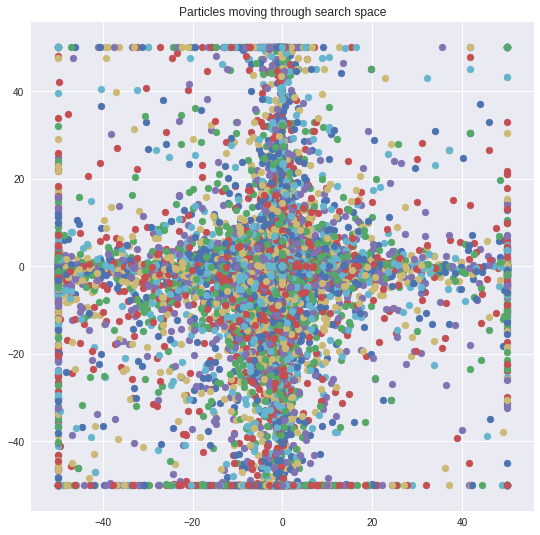

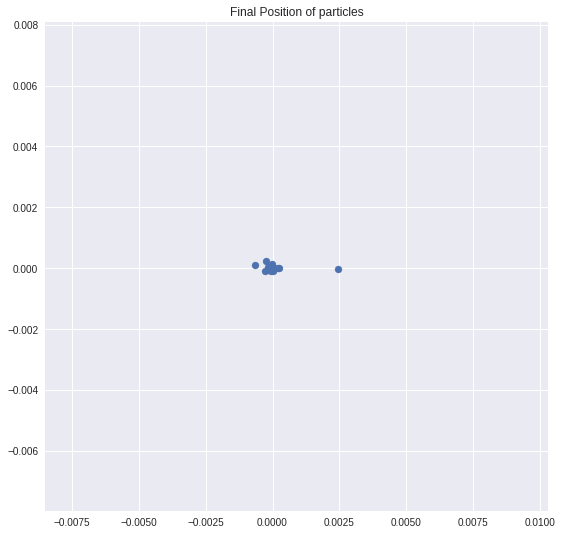

In [69]:
f_name = 'sphere'
best_fitness_history, best_global_position = sapso(n, m, n_dimensions, min_, max_, initial_inertia, final_inertia, c1, c2, c_max, d_low, d_high, f_name)
global_minimum = [0,0]

print('Best fitness found was {} \n and actual global minimum is{}'.format(best_global_position,global_minimum))
print('difference is: {}'.format(best_global_position-global_minimum))

Best fitness found was [0.99994973 3.00002945] 
 and actual global minimum is[1, 3]
difference is: [-5.02658895e-05  2.94477208e-05]


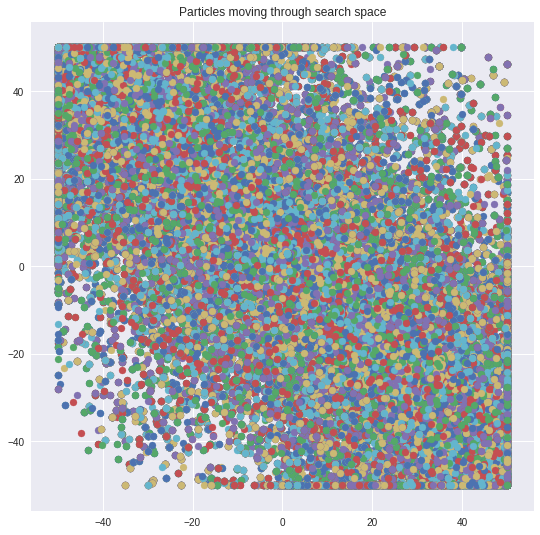

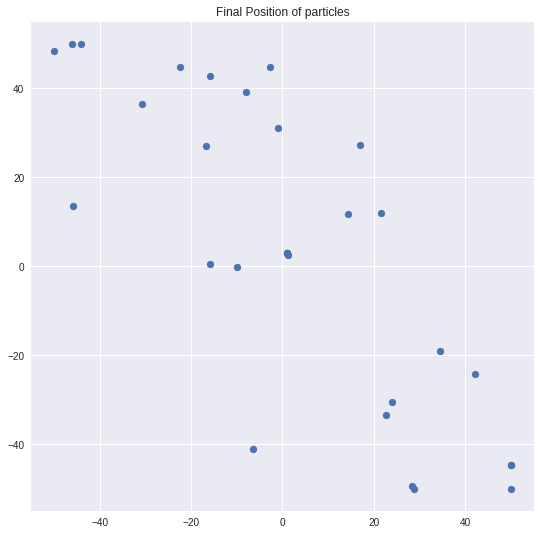

In [71]:
f_name = 'booth'
best_fitness_history, best_global_position = sapso(n, m, n_dimensions, min_, max_, initial_inertia, final_inertia, c1, c2, c_max, d_low, d_high, f_name)
global_minimum = [1,3]

print('Best fitness found was {} \n and actual global minimum is{}'.format(best_global_position,global_minimum))
print('difference is: {}'.format(best_global_position-global_minimum))

Best fitness found was [1.00074101 1.42828995] 
 and actual global minimum is[1, 1]
difference is: [0.00074101 0.42828995]


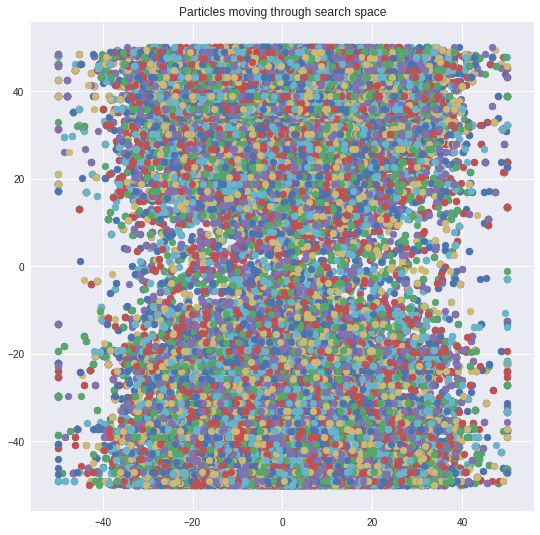

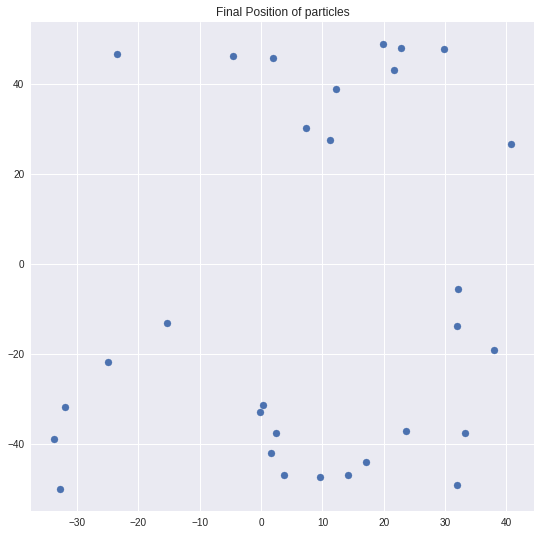

In [73]:
f_name = 'levi_13'
best_fitness_history, best_global_position = sapso(n, m, n_dimensions, min_, max_, initial_inertia, final_inertia, c1, c2, c_max, d_low, d_high, f_name)
global_minimum = [1,1]

print('Best fitness found was {} \n and actual global minimum is{}'.format(best_global_position,global_minimum))
print('difference is: {}'.format(best_global_position-global_minimum))